In [1]:
# cleaned up version

import glob
import os
import shutil
import warnings
import random

import matplotlib.pyplot as plt
#from PIL import Image
from sklearn.model_selection import train_test_split

import random
from matplotlib.image import imread
import pandas as pd


import keras
from keras.regularizers import l2
from keras.applications import VGG16
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Activation, BatchNormalization, InputLayer
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Hide all TensorFlow debugging logs

warnings.filterwarnings('ignore')
random.seed(42)


In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
%mkdir gtsrb-german-traffic-sign
%cd gtsrb-german-traffic-sign
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip gtsrb-german-traffic-sign.zip
%cd ..

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  inflating: train/5/00005_00054_00001.png  
  in

In [23]:
data_dir = './gtsrb-german-traffic-sign'
train_path = './gtsrb-german-traffic-sign/Train'
test_path = './gtsrb-german-traffic-sign/Test'

In [24]:
# Resizing the images to 32x32x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [25]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

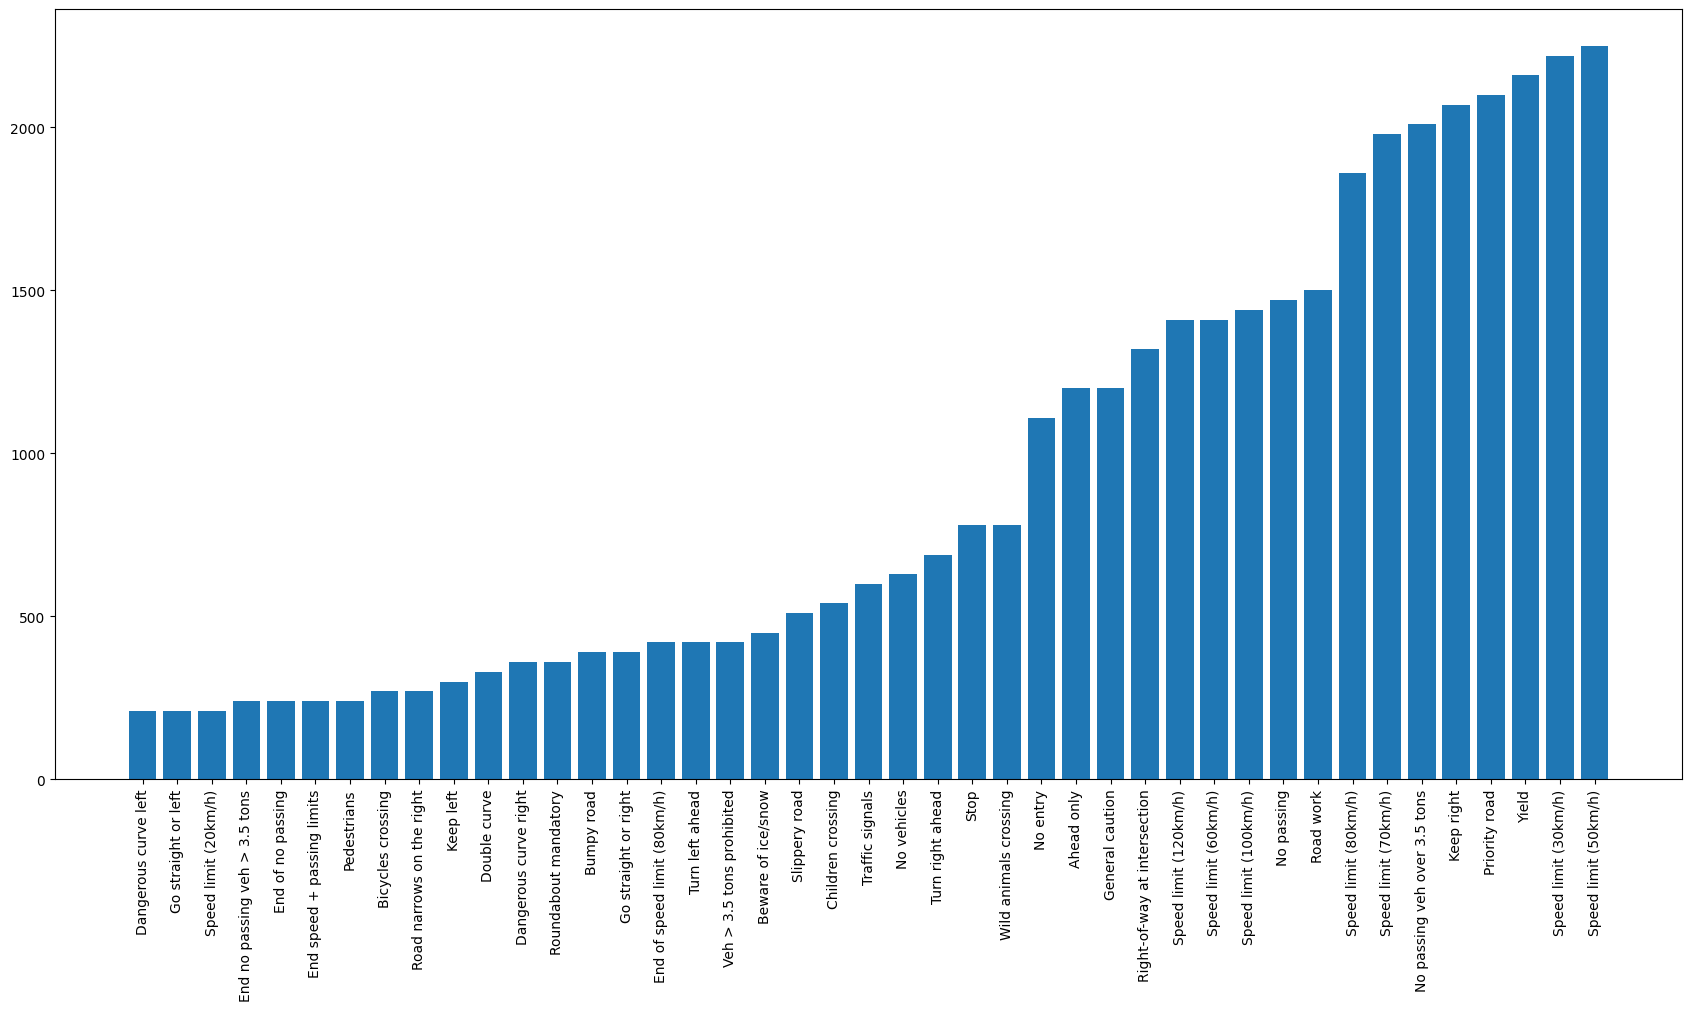

In [26]:
folders = glob.glob(f"{train_path}/*")

train_number = [len(glob.glob(f"{folder}/*")) for folder in folders]
class_num = [classes[int(folder.split('/')[-1])] for folder in folders]

# Sorting the dataset on the basis of number of images in each class
sorted_pairs = sorted(zip(train_number, class_num))

train_number, class_num = zip(*sorted_pairs)

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()


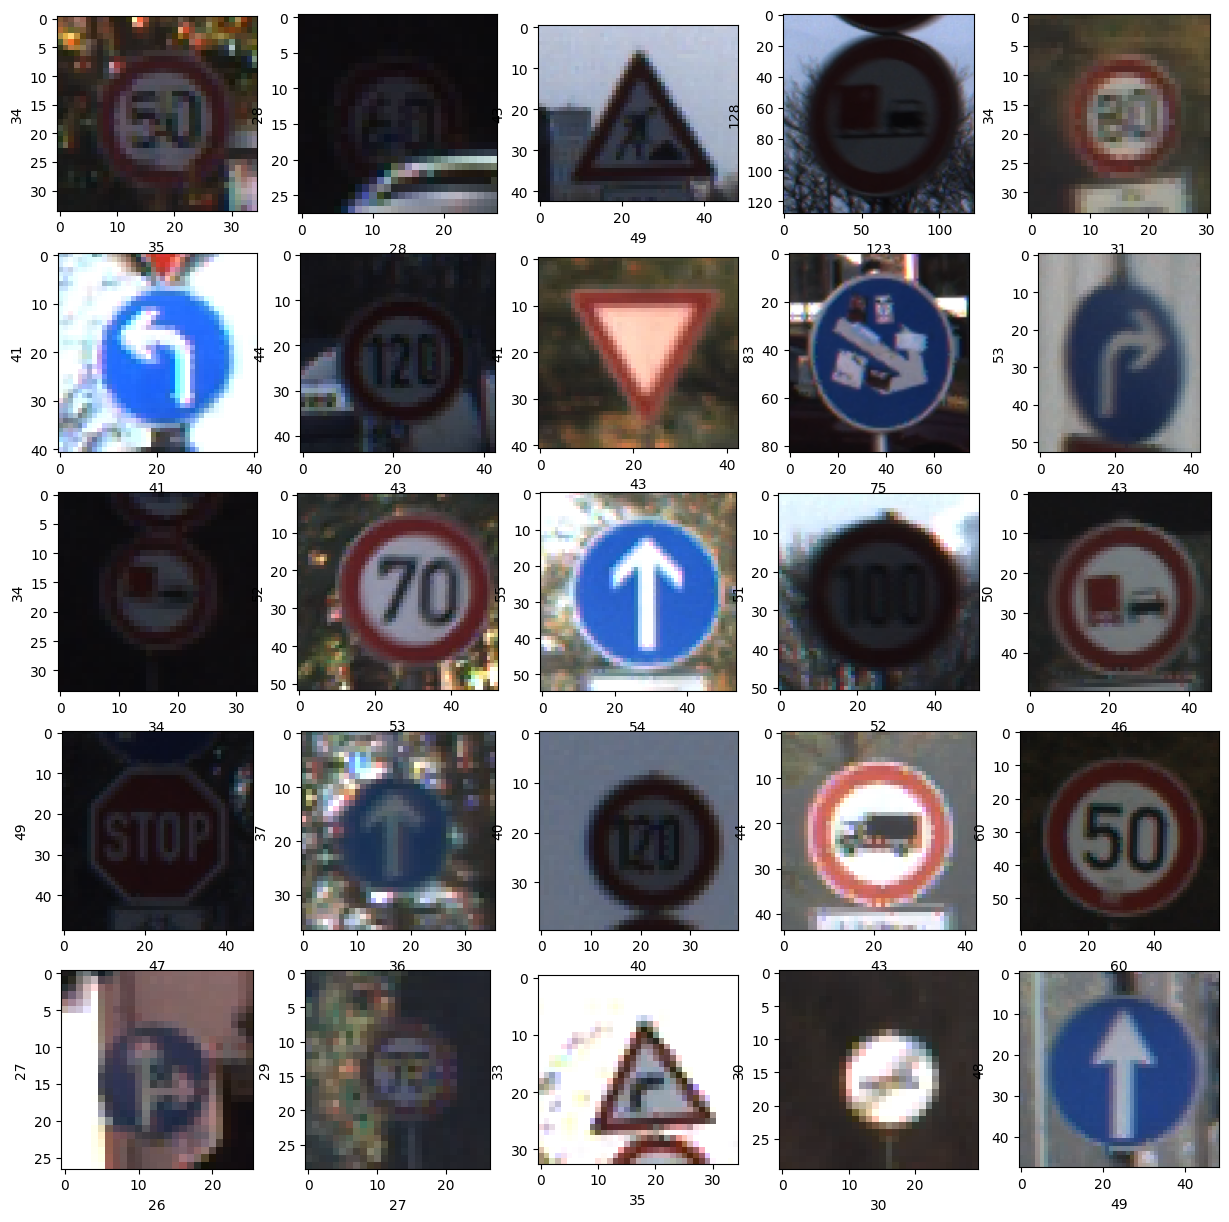

In [121]:
# Visualizing 25 random images from test data

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(15,15))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [122]:
# Define the ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3, # set validation split
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 27447 images belonging to 43 classes.
Found 11762 images belonging to 43 classes.


In [123]:
def create_callbacks():

    cpk_path = './best_model.h5'

    reducelr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=5,
        verbose=1
    )

    callbacks = [reducelr, earlystop]

    return callbacks

callbacks = create_callbacks()

In [124]:
def pretrained_model():
# load the VGG16 network, ensuring the head FC layer sets are left off
    baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

    # Initialize a Sequential model
    model = Sequential()
    model.add(InputLayer(input_shape=(32, 32, 3)))
    model.add(baseModel)
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))

    # It's a good idea to freeze the baseModel layers while training the newly added
    # This avoids large gradients updating the pretrained weights
    for layer in baseModel.layers:
      if layer.name == 'block5_conv1':
        break
      layer.trainable = False

    return model

In [125]:
lr = 0.001
epochs = 50
opt = Adam(lr=lr, decay=lr / (epochs * 0.5))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 43)                5547      
                                                      

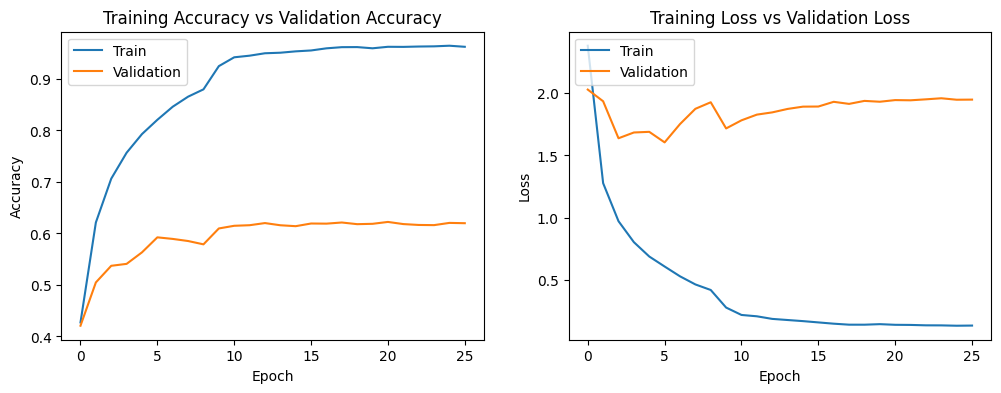

In [126]:
# Fit the model on the batches generated by datagen.flow().


pretrained_gtsrb = pretrained_model()
pretrained_gtsrb.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
pretrained_gtsrb.summary()
history = pretrained_gtsrb.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    callbacks = callbacks)

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [127]:
def custom_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))

    model.add(Dense(43, activation='softmax'))

    return model

In [128]:
lr = 0.001
epochs = 50
opt = Adam(lr=lr, decay=lr / (epochs * 0.5))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 batch_normalization_3 (Batc  (None, 15, 15, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                      

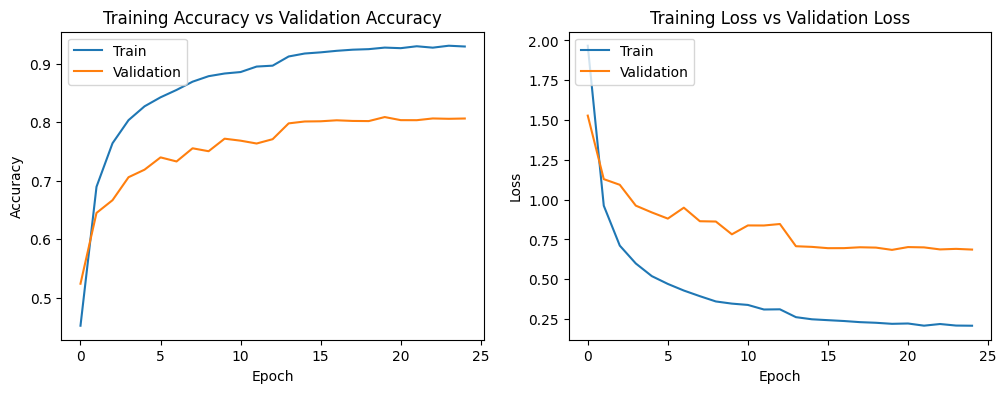

In [129]:
custom_gtsrb = custom_model()
custom_gtsrb.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
custom_gtsrb.summary()

history = custom_gtsrb.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = epochs,
                    callbacks = callbacks)

# ~40 ms/steps
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [45]:
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# cat vs dogs
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [46]:
# !pip install -q kaggle
# from google.colab import files
# files.upload()
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json
%mkdir kaggle-cat-vs-dog-dataset
%cd kaggle-cat-vs-dog-dataset
!kaggle datasets download -d karakaggle/kaggle-cat-vs-dog-dataset
!unzip kaggle-cat-vs-dog-dataset.zip
%cd ..

Streaming output truncated to the last 5000 lines.
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/549.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5490.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5491.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5492.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5493.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5494.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5495.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5496.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5497.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5498.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5499.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/55.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/550.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5500.jpg  
  inflating: kagglecatsanddogs_3367a/PetImages/Dog/5501.jpg  
  inflating: kagglecats

In [116]:
MAIN_PATH = './kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages'
CLASSES = os.listdir(MAIN_PATH)
NUM_CLASSES = 2
HEIGHT,WIDTH = 32,32
BATCH_SIZE = 32
SPLIT = 0.2
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=SPLIT)

train_ds = train_datagen.flow_from_directory(
    MAIN_PATH,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    subset = "training",
    class_mode = "categorical",
    shuffle = True
)

val_ds = train_datagen.flow_from_directory(
    MAIN_PATH,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    subset = "validation",
    class_mode = "categorical",
    shuffle = True
)

Found 19968 images belonging to 2 classes.
Found 4991 images belonging to 2 classes.


In [117]:
def pretrained_model_cat_dog():
# load the VGG16 network, ensuring the head FC layer sets are left off
    baseModel = VGG16(weights="imagenet", include_top=False, input_shape=[HEIGHT,WIDTH, 3])

    model = Sequential()
    model.add(InputLayer(input_shape=(32, 32, 3)))
    model.add(baseModel)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Dense(2, activation='sigmoid'))

    for layer in baseModel.layers:
      if layer.name == 'block5_conv1':
        break
      layer.trainable = False
      print('Layer ' + layer.name + ' frozen.')


    return model

In [112]:
# custom model

def custom_model_cat_dog():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))

    model.add(Dense(2, activation='sigmoid'))

    return model

In [113]:
def create_callbacks():

    cpk_path = './best_model.h5'

    reducelr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=5,
        verbose=1
    )

    callbacks = [reducelr, earlystop]

    return callbacks

In [114]:
keras.backend.clear_session()

pretrained_cat_dog = pretrained_model_cat_dog()
pretrained_cat_dog.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

callbacks = create_callbacks()

pretrained_cat_dog.summary()

Layer input_1 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 batch_normalization (BatchN  (None, 128)              5

Epoch 1/50
624/624 [==============================] - 49s 77ms/step - loss: 0.5831 - accuracy: 0.7142 - val_loss: 0.5196 - val_accuracy: 0.7482 - lr: 0.0010
Epoch 2/50
624/624 [==============================] - 47s 76ms/step - loss: 0.5065 - accuracy: 0.7595 - val_loss: 0.5177 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 3/50
624/624 [==============================] - 47s 75ms/step - loss: 0.4782 - accuracy: 0.7726 - val_loss: 0.4598 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 4/50
624/624 [==============================] - 48s 77ms/step - loss: 0.4665 - accuracy: 0.7793 - val_loss: 0.4795 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 5/50
624/624 [==============================] - 48s 76ms/step - loss: 0.4551 - accuracy: 0.7843 - val_loss: 0.4782 - val_accuracy: 0.7603 - lr: 0.0010
Epoch 6/50
624/624 [==============================] - 48s 77ms/step - loss: 0.4430 - accuracy: 0.7934 - val_loss: 0.4431 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 7/50
624/624 [==============================] - 48s 

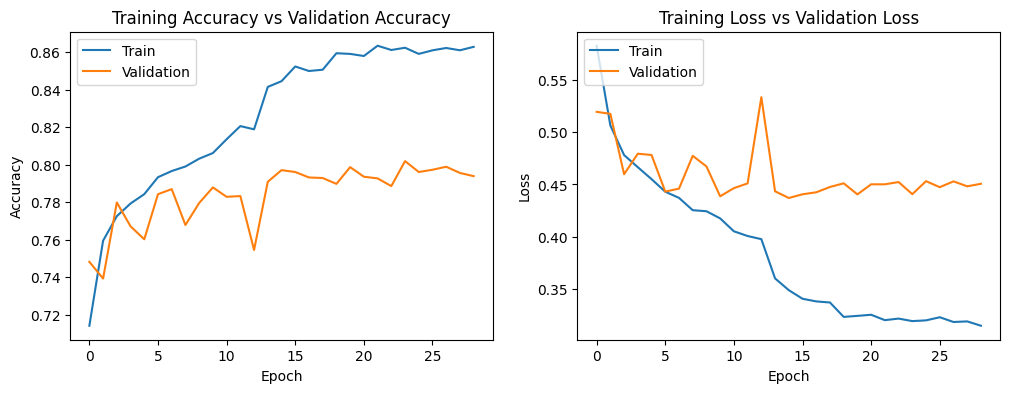

In [87]:
history = pretrained_cat_dog.fit(train_ds,
                    epochs = 50,
                    callbacks = callbacks,
                    validation_data = val_ds,
                    verbose = 1)
# peak 1k 75%

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

# 72% with the 64 dense layer

In [57]:
custom_cat_dog = custom_model_cat_dog()
custom_cat_dog.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

callbacks = create_callbacks()

custom_cat_dog.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                        

Epoch 1/50
624/624 [==============================] - 47s 74ms/step - loss: 0.7683 - accuracy: 0.5943 - val_loss: 0.6519 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 2/50
624/624 [==============================] - 45s 73ms/step - loss: 0.6304 - accuracy: 0.6571 - val_loss: 0.5757 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 3/50
624/624 [==============================] - 46s 74ms/step - loss: 0.5870 - accuracy: 0.6840 - val_loss: 0.5610 - val_accuracy: 0.7119 - lr: 0.0010
Epoch 4/50
624/624 [==============================] - 46s 74ms/step - loss: 0.5690 - accuracy: 0.7017 - val_loss: 0.6618 - val_accuracy: 0.6428 - lr: 0.0010
Epoch 5/50
624/624 [==============================] - 46s 74ms/step - loss: 0.5628 - accuracy: 0.7107 - val_loss: 0.5442 - val_accuracy: 0.7183 - lr: 0.0010
Epoch 6/50
624/624 [==============================] - 47s 75ms/step - loss: 0.5532 - accuracy: 0.7139 - val_loss: 0.5494 - val_accuracy: 0.7147 - lr: 0.0010
Epoch 7/50
624/624 [==============================] - 46s 

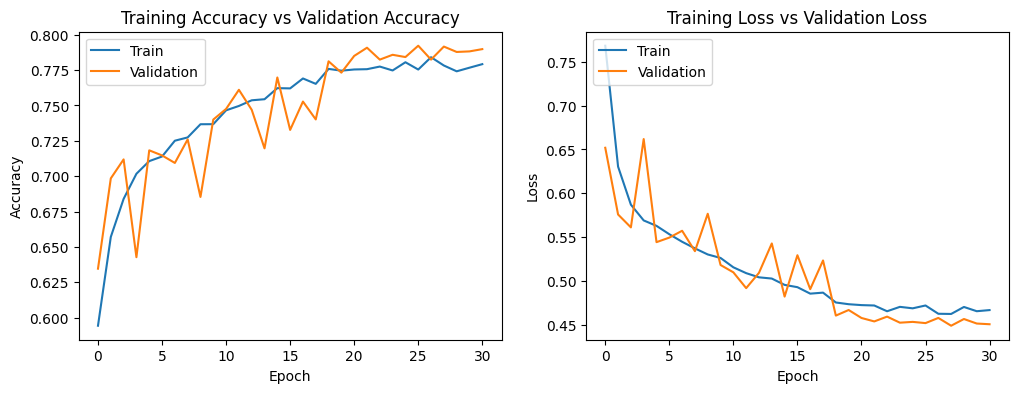

In [58]:
history = custom_cat_dog.fit(train_ds,
                    epochs = 50,
                    callbacks = callbacks,
                    validation_data = val_ds,
                    verbose = 1)

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [88]:
# limit the data to 1k sample

MAIN_PATH = './kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages'
CLASSES = os.listdir(MAIN_PATH)


# List all file paths
file_paths = []
labels = []
for label in CLASSES:
    dir_path = os.path.join(MAIN_PATH, label)
    files = os.listdir(dir_path)
    for file in files:
        file_paths.append(os.path.join(dir_path, file))
        labels.append(label)

# Create a DataFrame
data = pd.DataFrame({'path': file_paths, 'label': labels})

# Shuffle the DataFrame
data = data.sample(frac=1.0, random_state=42)

# Take the first N
N = 1000  # Adjust based on your desired subset size
subset = data.iloc[:N]

# Create a new directory and copy those images to that directory
subset_dir = './subset'
os.makedirs(subset_dir, exist_ok=True)

for _, row in subset.iterrows():
    class_dir = os.path.join(subset_dir, row['label'])
    os.makedirs(class_dir, exist_ok=True)
    dest_path = os.path.join(class_dir, row['path'].split('/')[-1])
    shutil.copyfile(row['path'], dest_path)

# Now use subset_dir as your main path
MAIN_PATH = subset_dir



NUM_CLASSES = 2
HEIGHT,WIDTH = 32,32
BATCH_SIZE = 32
SPLIT = 0.2
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=SPLIT)

train_ds = train_datagen.flow_from_directory(
    MAIN_PATH,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    subset = "training",
    class_mode = "categorical",
    shuffle = True
)

val_ds = train_datagen.flow_from_directory(
    MAIN_PATH,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    subset = "validation",
    class_mode = "categorical",
    shuffle = True
)



Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [89]:
pretrained_cat_dog_limited = pretrained_model_cat_dog()
pretrained_cat_dog_limited.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

callbacks = create_callbacks()

pretrained_cat_dog_limited.summary()

Layer input_3 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)             

Epoch 1/50
25/25 [==============================] - 3s 92ms/step - loss: 0.7830 - accuracy: 0.5894 - val_loss: 0.6659 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 2s 87ms/step - loss: 0.6097 - accuracy: 0.6944 - val_loss: 1.0119 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 2s 82ms/step - loss: 0.5938 - accuracy: 0.7025 - val_loss: 0.5879 - val_accuracy: 0.6675 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 2s 78ms/step - loss: 0.5457 - accuracy: 0.7325 - val_loss: 0.5623 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 2s 79ms/step - loss: 0.5251 - accuracy: 0.7506 - val_loss: 0.5905 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 2s 78ms/step - loss: 0.4861 - accuracy: 0.7563 - val_loss: 0.5372 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 2s 77ms/step - loss: 0.4

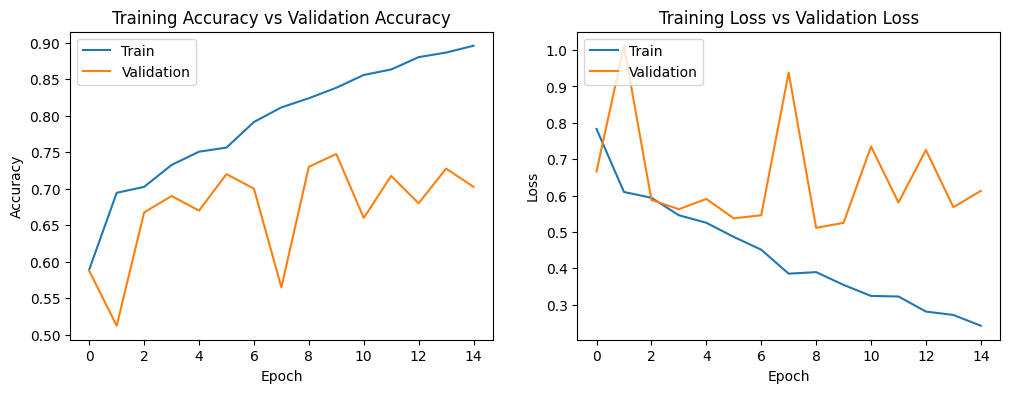

In [90]:
history = pretrained_cat_dog_limited.fit(train_ds,
                    epochs = 50,
                    callbacks = callbacks,
                    validation_data = val_ds,
                    verbose = 1)
# peak 1k 75%
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [91]:
custom_cat_dog_limited = custom_model_cat_dog()
custom_cat_dog_limited.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

callbacks = create_callbacks()

custom_cat_dog_limited.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 batch_normalization_2 (Batc  (None, 15, 15, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                      

Epoch 1/50
25/25 [==============================] - 3s 83ms/step - loss: 1.0090 - accuracy: 0.5169 - val_loss: 0.7046 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 2s 98ms/step - loss: 0.9080 - accuracy: 0.5406 - val_loss: 0.6916 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 2s 77ms/step - loss: 0.8499 - accuracy: 0.5581 - val_loss: 0.6870 - val_accuracy: 0.5325 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 2s 76ms/step - loss: 0.8099 - accuracy: 0.5906 - val_loss: 0.6908 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 2s 75ms/step - loss: 0.8009 - accuracy: 0.5819 - val_loss: 0.6824 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 2s 75ms/step - loss: 0.7565 - accuracy: 0.6044 - val_loss: 0.6851 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 2s 77ms/step - loss: 0.7

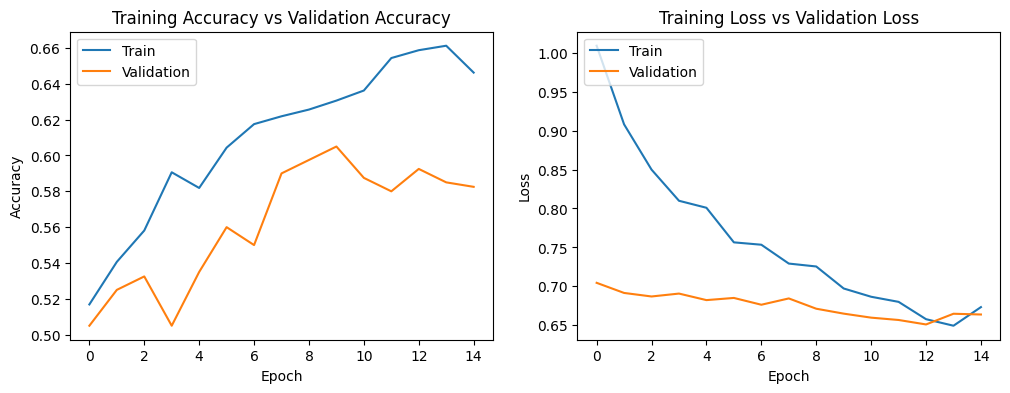

In [92]:
history = custom_cat_dog_limited.fit(train_ds,
                    epochs = 50,
                    callbacks = callbacks,
                    validation_data = val_ds,
                    verbose = 1)
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()